In [ ]:
# Librerías a utilizar
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import KElbowVisualizer
from warnings import simplefilter

# Desactivar mensajes de advertencia innecesarios
simplefilter(action = "ignore", category = FutureWarning)

# Cargar datos en dataframe
# facturas comerciales
url_data = 'https://drive.google.com/file/d/1Q7UMxmgWXjDkWKQTzGvAWQ3x3xmx7Z99/view?usp=sharing'
url_data = 'https://drive.google.com/uc?id=' + url_data.split('/')[-2]
df = pd.read_csv(url_data, sep = ";")

# Se reordenan las columnas para facilitar la lectura.
df = df[['emisor', 'fecha', 'porcentaje_precio', 'valor_nominal_usd', 'valor_efectivo_usd', 'fecha_emision', 'fecha_vencimiento', 'porcentaje_rendimiento', 'procedencia', 'observaciones']]

# Mostrar los primeros registros
df.head()

,emisor,fecha,porcentaje_precio,valor_nominal_usd,valor_efectivo_usd,fecha_emision,fecha_vencimiento,porcentaje_rendimiento,procedencia,observaciones
0,ABSORPELSA PAPELES ABSORVENTES SA,03/01/2023,95.4414,20841.05,19890.98,03/01/2023,02/07/2023,9.50,Q,ACEPTANTE: SURGALARE S.A. - RUC: 0992730048001...
1,ABSORPELSA PAPELES ABSORVENTES SA,03/01/2023,95.0627,52696.63,50094.86,03/01/2023,02/07/2023,10.33,Q,ACEPTANTE: SURGALARE S.A. - RUC: 0992730048001...
2,IMPVET IMPORTADORA VETERINARIA CIA LTDA,04/01/2023,97.7199,5587.97,5460.56,12/12/2022,11/04/2023,8.75,Q,ACEPTANTE: INCUBADORA ANDINA S.A. - RUC: 18901...
3,ABSORPELSA PAPELES ABSORVENTES SA,04/01/2023,96.7326,13254.19,12821.12,03/01/2023,12/05/2023,9.50,Q,ACEPTANTE: SURGALARE S.A. - RUC: 0992730048001...
4,ABSORPELSA PAPELES ABSORVENTES SA,04/01/2023,95.3516,5400.97,5149.91,03/01/2023,02/07/2023,9.75,Q,ACEPTANTE: SURGALARE S.A. - RUC: 0992730048001...


In [ ]:
# Cambiar el tipo de datos para poder restar las fechas y separar año y mes.
df["fecha_transaccion"] = pd.to_datetime(df["fecha"], format='%d/%m/%Y')
df["fecha_emision"] = pd.to_datetime(df["fecha_emision"], format='%d/%m/%Y')
df["fecha_vencimiento"] = pd.to_datetime(df["fecha_vencimiento"], format='%d/%m/%Y')

# Se crea una nueva columna restando la fecha de vencimiento y la fecha de emisión.
df["dias_plazo"] = (df["fecha_vencimiento"] - df["fecha_emision"]) / np.timedelta64(1, 'D')

# Se separa año y mes de cada campo de fecha
df["anio_transaccion"] = df["fecha_transaccion"].dt.year
df["mes_transaccion"] = df["fecha_transaccion"].dt.month
df["anio_emision"] = df["fecha_emision"].dt.year
df["mes_emision"] = df["fecha_emision"].dt.month
df["anio_vencimiento"] = df["fecha_vencimiento"].dt.year
df["mes_vencimiento"] = df["fecha_vencimiento"].dt.month

# Se quitan espacios en blanco al inicio y al final del campo de texto.
df["observaciones"] = df["observaciones"].str.strip()

# Se eliminan las columnas de fecha originales, por cuanto ya no se van a usar.
df = df.drop(["fecha"], axis = 1)
df = df.drop(["fecha_transaccion"], axis = 1)
df = df.drop(["fecha_emision"], axis = 1)
df = df.drop(["fecha_vencimiento"], axis = 1)

# El algoritmo K-means trabaja con números, por lo que se aplica la codificación one hot encoder para convertir los valores categóticos en columnas binarias, con valores 1 o 0.

# Listar las columnas categóricas.
categorical_cols = ['procedencia', 'observaciones']

df = pd.get_dummies(df, columns = categorical_cols)
df

,emisor,porcentaje_precio,valor_nominal_usd,valor_efectivo_usd,porcentaje_rendimiento,dias_plazo,anio_transaccion,mes_transaccion,anio_emision,mes_emision,...,observaciones_ACEPTANTE: INDUSTRIA CARTONERA ECUATORIANA S.A. - RUC: 0990027900001,observaciones_ACEPTANTE: INDUSTRIAS ALES - RUC: 1390000991001,observaciones_ACEPTANTE: ITALIMENTOS CIA. LTDA. - RUC: 0190340449001,observaciones_ACEPTANTE: JUNTA DE BENEFICENCIA DE GUAYAQUIL - RUC: 0990967946001,observaciones_ACEPTANTE: LIRIS S.A. - RUC: 0990865477001,observaciones_ACEPTANTE: REPAPERS RECICLAJE DEL ECUADOR S.A. - RUC 0992800623001,observaciones_ACEPTANTE: RIVERAGRO S.A. - RUC: 0992778792001,observaciones_ACEPTANTE: STUP S.A. - RUC: 0992280395001,observaciones_ACEPTANTE: SURGALARE S.A. - RUC: 0992730048001,observaciones_ACEPTANTE: TOLKIEN S.A. - RUC: 0992645652001
0,ABSORPELSA PAPELES ABSORVENTES SA,95.4414,20841.05,19890.98,9.50,180.0,2023,1,2023,1,...,0,0,0,0,0,0,0,0,1,0
1,ABSORPELSA PAPELES ABSORVENTES SA,95.0627,52696.63,50094.86,10.33,180.0,2023,1,2023,1,...,0,0,0,0,0,0,0,0,1,0
2,IMPVET IMPORTADORA VETERINARIA CIA LTDA,97.7199,5587.97,5460.56,8.75,120.0,2023,1,2022,12,...,0,0,0,0,0,0,0,0,0,0
3,ABSORPELSA PAPELES ABSORVENTES SA,96.7326,13254.19,12821.12,9.50,129.0,2023,1,2023,1,...,0,0,0,0,0,0,0,0,1,0
4,ABSORPELSA PAPELES ABSORVENTES SA,95.3516,5400.97,5149.91,9.75,180.0,2023,1,2023,1,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3675,PRODUCTORA CARTONERA S.A.,95.6938,10604.50,10147.85,9.00,180.0,2022,12,2022,12,...,0,0,0,0,0,0,0,0,0,0
3676,PRODUCTORA CARTONERA S.A.,97.8966,26169.68,25619.22,8.50,91.0,2022,12,2022,12,...,0,0,0,0,0,0,0,0,0,0
3677,NEDERAGRO S A,97.9192,172000.00,168421.05,8.50,90.0,2022,12,2022,12,...,0,0,0,0,0,0,0,0,0,0
3678,NEDERAGRO S A,97.6708,157600.00,153929.22,8.50,100.0,2022,12,2022,12,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Crear un nuevo dataframe sin el listado de emisores
df_ftr = df.drop(["emisor"], axis = 1)

# Mostrar los primeros registros
df_ftr.head()

,porcentaje_precio,valor_nominal_usd,valor_efectivo_usd,porcentaje_rendimiento,dias_plazo,anio_transaccion,mes_transaccion,anio_emision,mes_emision,anio_vencimiento,...,observaciones_ACEPTANTE: INDUSTRIA CARTONERA ECUATORIANA S.A. - RUC: 0990027900001,observaciones_ACEPTANTE: INDUSTRIAS ALES - RUC: 1390000991001,observaciones_ACEPTANTE: ITALIMENTOS CIA. LTDA. - RUC: 0190340449001,observaciones_ACEPTANTE: JUNTA DE BENEFICENCIA DE GUAYAQUIL - RUC: 0990967946001,observaciones_ACEPTANTE: LIRIS S.A. - RUC: 0990865477001,observaciones_ACEPTANTE: REPAPERS RECICLAJE DEL ECUADOR S.A. - RUC 0992800623001,observaciones_ACEPTANTE: RIVERAGRO S.A. - RUC: 0992778792001,observaciones_ACEPTANTE: STUP S.A. - RUC: 0992280395001,observaciones_ACEPTANTE: SURGALARE S.A. - RUC: 0992730048001,observaciones_ACEPTANTE: TOLKIEN S.A. - RUC: 0992645652001
0,95.4414,20841.05,19890.98,9.50,180.0,2023,1,2023,1,2023,...,0,0,0,0,0,0,0,0,1,0
1,95.0627,52696.63,50094.86,10.33,180.0,2023,1,2023,1,2023,...,0,0,0,0,0,0,0,0,1,0
2,97.7199,5587.97,5460.56,8.75,120.0,2023,1,2022,12,2023,...,0,0,0,0,0,0,0,0,0,0
3,96.7326,13254.19,12821.12,9.50,129.0,2023,1,2023,1,2023,...,0,0,0,0,0,0,0,0,1,0
4,95.3516,5400.97,5149.91,9.75,180.0,2023,1,2023,1,2023,...,0,0,0,0,0,0,0,0,1,0


In [ ]:
# Descripción del dataframe
df_ftr.describe()

,porcentaje_precio,valor_nominal_usd,valor_efectivo_usd,porcentaje_rendimiento,dias_plazo,anio_transaccion,mes_transaccion,anio_emision,mes_emision,anio_vencimiento,...,observaciones_ACEPTANTE: INDUSTRIA CARTONERA ECUATORIANA S.A. - RUC: 0990027900001,observaciones_ACEPTANTE: INDUSTRIAS ALES - RUC: 1390000991001,observaciones_ACEPTANTE: ITALIMENTOS CIA. LTDA. - RUC: 0190340449001,observaciones_ACEPTANTE: JUNTA DE BENEFICENCIA DE GUAYAQUIL - RUC: 0990967946001,observaciones_ACEPTANTE: LIRIS S.A. - RUC: 0990865477001,observaciones_ACEPTANTE: REPAPERS RECICLAJE DEL ECUADOR S.A. - RUC 0992800623001,observaciones_ACEPTANTE: RIVERAGRO S.A. - RUC: 0992778792001,observaciones_ACEPTANTE: STUP S.A. - RUC: 0992280395001,observaciones_ACEPTANTE: SURGALARE S.A. - RUC: 0992730048001,observaciones_ACEPTANTE: TOLKIEN S.A. - RUC: 0992645652001
count,3680.000000,3680.000000,3680.000000,3680.000000,3680.000000,3680.000000,3680.000000,3680.000000,3680.000000,3680.000000,...,3680.000000,3680.000000,3680.000000,3680.000000,3680.000000,3680.000000,3680.000000,3680.000000,3680.000000,3680.000000
mean,96.845728,24265.176726,23528.840709,8.852886,143.377174,2022.198370,5.410054,2022.160326,5.460054,2022.417391,...,0.023098,0.024728,0.008424,0.012228,0.019837,0.103804,0.001359,0.010054,0.092391,0.059239
std,1.179161,41930.626942,40805.873975,0.567858,42.331233,0.398826,3.146346,0.413620,3.196140,0.493196,...,0.150235,0.155317,0.091407,0.109918,0.139459,0.305048,0.036840,0.099780,0.289617,0.236104
min,95.062700,192.820000,188.900000,1.000000,16.000000,2022.000000,1.000000,2021.000000,1.000000,2022.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,95.900300,6929.842500,6700.722500,8.750000,120.000000,2022.000000,3.000000,2022.000000,3.000000,2022.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,96.490500,14533.905000,14035.625000,9.000000,153.000000,2022.000000,5.000000,2022.000000,5.000000,2022.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,97.632400,24601.340000,23789.247500,9.000000,180.000000,2022.000000,8.000000,2022.000000,8.000000,2023.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,99.770000,516995.460000,514195.970000,10.410000,180.000000,2023.000000,12.000000,2023.000000,12.000000,2023.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
# Realizar el escalado de datos para que las columnas estén en un rango de 0 y 1
# Las columnas que fueron convertidas a one hot no se ven afectadas por esta operación porque ya están entre 0 y 1.
df_sc = (df_ftr - df_ftr.min()) / (df_ftr.max() - df_ftr.min())

# Confirmar que los valores estén entre 0 y 1
df_sc.describe()

,porcentaje_precio,valor_nominal_usd,valor_efectivo_usd,porcentaje_rendimiento,dias_plazo,anio_transaccion,mes_transaccion,anio_emision,mes_emision,anio_vencimiento,...,observaciones_ACEPTANTE: INDUSTRIA CARTONERA ECUATORIANA S.A. - RUC: 0990027900001,observaciones_ACEPTANTE: INDUSTRIAS ALES - RUC: 1390000991001,observaciones_ACEPTANTE: ITALIMENTOS CIA. LTDA. - RUC: 0190340449001,observaciones_ACEPTANTE: JUNTA DE BENEFICENCIA DE GUAYAQUIL - RUC: 0990967946001,observaciones_ACEPTANTE: LIRIS S.A. - RUC: 0990865477001,observaciones_ACEPTANTE: REPAPERS RECICLAJE DEL ECUADOR S.A. - RUC 0992800623001,observaciones_ACEPTANTE: RIVERAGRO S.A. - RUC: 0992778792001,observaciones_ACEPTANTE: STUP S.A. - RUC: 0992280395001,observaciones_ACEPTANTE: SURGALARE S.A. - RUC: 0992730048001,observaciones_ACEPTANTE: TOLKIEN S.A. - RUC: 0992645652001
count,3680.000000,3680.000000,3680.000000,3680.000000,3680.000000,3680.000000,3680.000000,3680.000000,3680.000000,3680.000000,...,3680.000000,3680.000000,3680.000000,3680.000000,3680.000000,3680.000000,3680.000000,3680.000000,3680.000000,3680.000000
mean,0.378779,0.046579,0.045408,0.834526,0.776690,0.198370,0.400914,0.580163,0.405459,0.417391,...,0.023098,0.024728,0.008424,0.012228,0.019837,0.103804,0.001359,0.010054,0.092391,0.059239
std,0.250496,0.081135,0.079388,0.060346,0.258117,0.398826,0.286031,0.206810,0.290558,0.493196,...,0.150235,0.155317,0.091407,0.109918,0.139459,0.305048,0.036840,0.099780,0.289617,0.236104
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.177936,0.013036,0.012669,0.823592,0.634146,0.000000,0.181818,0.500000,0.181818,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.303316,0.027750,0.026939,0.850159,0.835366,0.000000,0.363636,0.500000,0.363636,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.545897,0.047230,0.045914,0.850159,1.000000,0.000000,0.636364,0.500000,0.636364,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


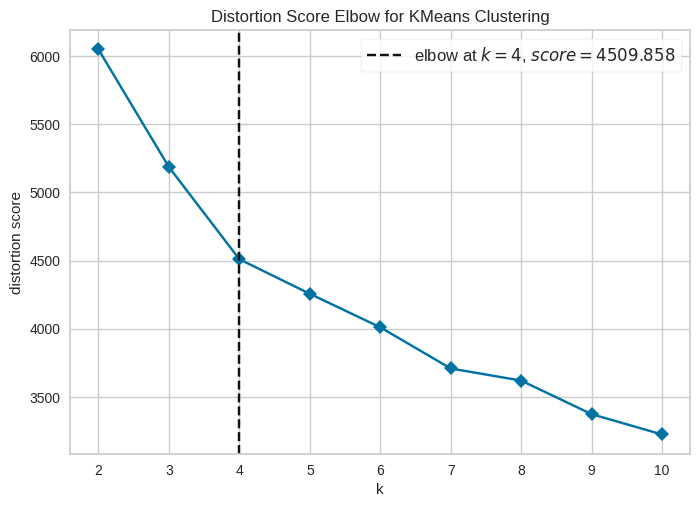

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [ ]:
# Utilizar el "elbow method" para calcular el número óptimo de clústeres.
# Parámetros:
# model: el modelo que se va a avaluar, en este caso KMeans
# k: el rango de clústeres que se van a probar, en este caso, de 1 a 10. Se coloca 11 porque en la sintaxis ese valor no está incluido.
# timings: Se coloca False para que no se muestre una línea con los tiempos de entrenamiento para cada iteración. No es relevante y de esa manera se aprecia mejor el gráfico.
# metric: la métrica por defecto es distortion, sin embargo hay otras opciones como silhouette y calinski_harabasz.

# Usando la métrica distortion:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(10), metric='distortion', timings=False)
visualizer.fit(df_sc)
visualizer.show()

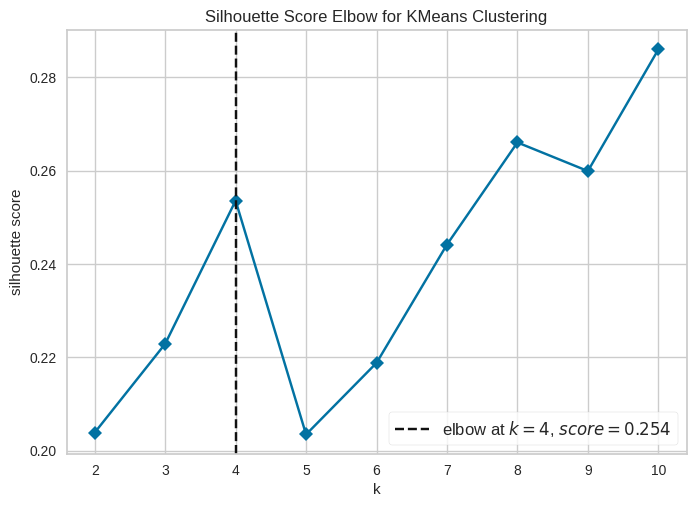

<Axes: title={'center': 'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [ ]:
# Usando la métrica silhouette:
visualizer = KElbowVisualizer(model, k=(10), metric='silhouette', timings=False)
visualizer.fit(df_sc)
visualizer.show()

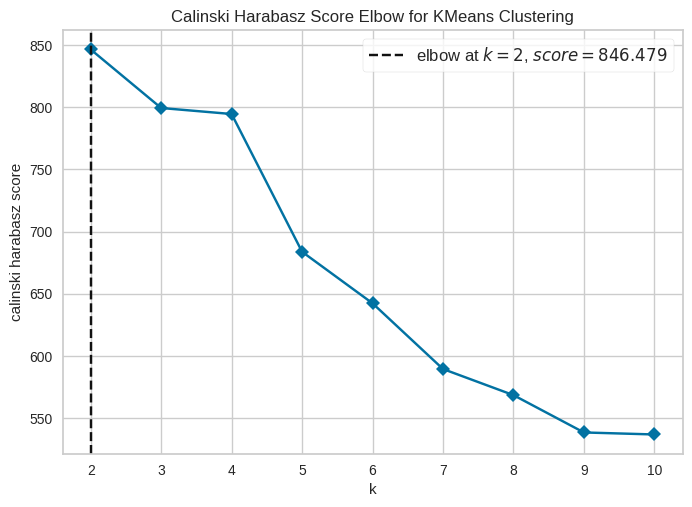

<Axes: title={'center': 'Calinski Harabasz Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='calinski harabasz score'>

In [ ]:
# Usando la métrica calinski_harabasz:
visualizer = KElbowVisualizer(model, k=(10), metric='calinski_harabasz', timings=False)
visualizer.fit(df_sc)
visualizer.show()

In [ ]:
# No todas las métricas son apropiadas para el mismo set de datos. En este caso 2 de 3 gráficos dieron como resultado que el número óptimo de clústeres para el presente dataset es 4

# Aplicar el algoritmo K-means
# Parámetros:
# n_clusters: El número de clústeres en que se vana dividir los datos, el cual fue calculado previamente.
# init: selecciona los centroides iniciales de cada clúster utilizando un mustreo que se base en una distribución probable empírica de los puntos. Se utiliza k-means++.
# random_state: Los registros se procesan aleatoriamente. Para facilitar el seguimiento, se usa un número entero, ejemplo el 42, para que en cada ejecución se mantenga este orden.

kmeans_model = KMeans(n_clusters = 4, init = "k-means++", random_state = 42)
kmeans_model.fit(df_sc)

# Crear un nuevo dataset con los datos del original más una nueva columna con el número de clúster que se le asignó a la instancia.
df_c = df
df_c["cluster"] = kmeans_model.labels_
df_sc_c = df_sc
df_sc_c["cluster"] = kmeans_model.labels_
df_c.head()

,emisor,porcentaje_precio,valor_nominal_usd,valor_efectivo_usd,porcentaje_rendimiento,dias_plazo,anio_transaccion,mes_transaccion,anio_emision,mes_emision,...,observaciones_ACEPTANTE: INDUSTRIAS ALES - RUC: 1390000991001,observaciones_ACEPTANTE: ITALIMENTOS CIA. LTDA. - RUC: 0190340449001,observaciones_ACEPTANTE: JUNTA DE BENEFICENCIA DE GUAYAQUIL - RUC: 0990967946001,observaciones_ACEPTANTE: LIRIS S.A. - RUC: 0990865477001,observaciones_ACEPTANTE: REPAPERS RECICLAJE DEL ECUADOR S.A. - RUC 0992800623001,observaciones_ACEPTANTE: RIVERAGRO S.A. - RUC: 0992778792001,observaciones_ACEPTANTE: STUP S.A. - RUC: 0992280395001,observaciones_ACEPTANTE: SURGALARE S.A. - RUC: 0992730048001,observaciones_ACEPTANTE: TOLKIEN S.A. - RUC: 0992645652001,cluster
0,ABSORPELSA PAPELES ABSORVENTES SA,95.4414,20841.05,19890.98,9.50,180.0,2023,1,2023,1,...,0,0,0,0,0,0,0,1,0,1
1,ABSORPELSA PAPELES ABSORVENTES SA,95.0627,52696.63,50094.86,10.33,180.0,2023,1,2023,1,...,0,0,0,0,0,0,0,1,0,1
2,IMPVET IMPORTADORA VETERINARIA CIA LTDA,97.7199,5587.97,5460.56,8.75,120.0,2023,1,2022,12,...,0,0,0,0,0,0,0,0,0,1
3,ABSORPELSA PAPELES ABSORVENTES SA,96.7326,13254.19,12821.12,9.50,129.0,2023,1,2023,1,...,0,0,0,0,0,0,0,1,0,1
4,ABSORPELSA PAPELES ABSORVENTES SA,95.3516,5400.97,5149.91,9.75,180.0,2023,1,2023,1,...,0,0,0,0,0,0,0,1,0,1


In [ ]:
# Observar la cantidad de instancias asignadas a cada clúster.
df_c.groupby(["cluster"])["cluster"].count()

cluster
0     609
1     618
2     691
3    1762
Name: cluster, dtype: int64

In [ ]:
# Verificar el promedo del silhouette score para comprobar qué tan buena fue la clasificación en los clústeres. Un valor cercano a 1 es mejor.
silhouette_score_mean = silhouette_score(df_sc_c, df_sc_c["cluster"])
print(silhouette_score_mean)

0.34916961314518874


In [ ]:
# Aplicar PCA (Análisis de componentes principales) para facilitar una representación gráfica en dos dimensiones.
from sklearn.decomposition import PCA
pca = PCA(n_components = 2)
pca_df_sc_c = pca.fit_transform(df_sc)
pca_df_sc_c = pd.DataFrame(data = pca_df_sc_c, columns = ["Variable_1", "Variable_2"])
pca_df_sc_c = pd.concat([pca_df_sc_c, df_sc_c[["cluster"]]], axis = 1)

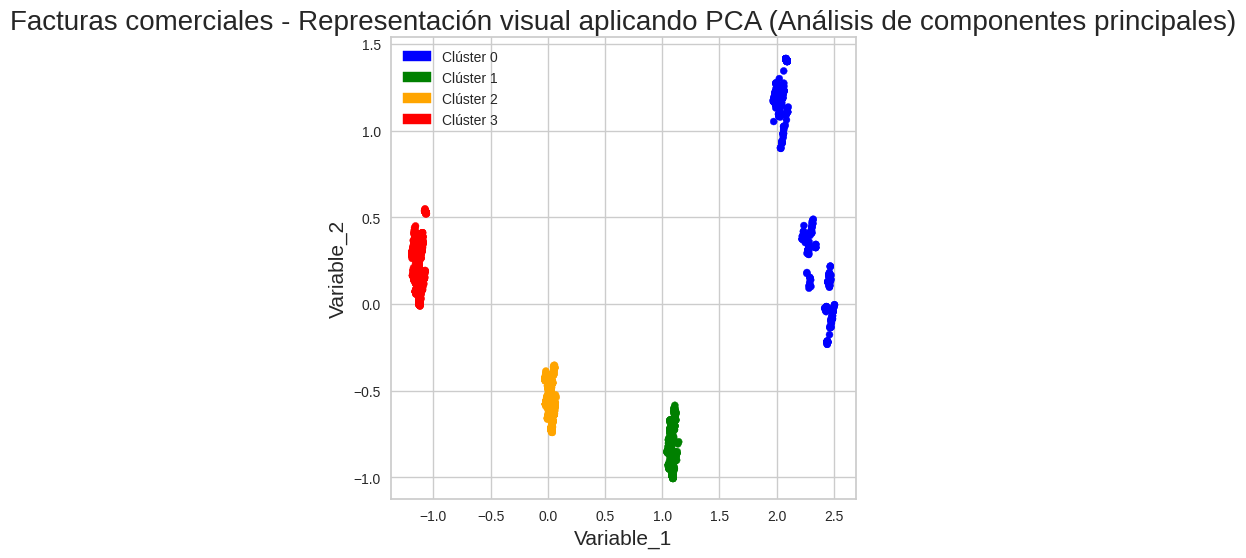

In [ ]:
# Realizar gráfico, dándole un color diferente a cada clúster para mejor apreciación.
fig = plt.figure(figsize = (6,6))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel("Variable_1", fontsize = 15)
ax.set_ylabel("Variable_2", fontsize = 15)
ax.set_title("Facturas comerciales - Representación visual aplicando PCA (Análisis de componentes principales)", fontsize = 20)
color = np.array(["blue", "green", "orange", "red"])
ax.scatter(x = pca_df_sc_c.Variable_1, y = pca_df_sc_c.Variable_2, c = color[pca_df_sc_c.cluster], s = 25)

# Crear etiquetas de la leyenda.
azul = mpatches.Patch(color = "blue", label = "Clúster 0")
verde = mpatches.Patch(color = "green", label = "Clúster 1")
naranja = mpatches.Patch(color = "orange", label = "Clúster 2")
rojo = mpatches.Patch(color = "red", label = "Clúster 3")

# Colocar la leyenda.
plt.legend(handles = [azul, verde, naranja, rojo])

plt.show()

In [ ]:
# Consultar los miembros de cada clúster
df[df.cluster == 0]

,emisor,porcentaje_precio,valor_nominal_usd,valor_efectivo_usd,porcentaje_rendimiento,dias_plazo,anio_transaccion,mes_transaccion,anio_emision,mes_emision,...,observaciones_ACEPTANTE: INDUSTRIAS ALES - RUC: 1390000991001,observaciones_ACEPTANTE: ITALIMENTOS CIA. LTDA. - RUC: 0190340449001,observaciones_ACEPTANTE: JUNTA DE BENEFICENCIA DE GUAYAQUIL - RUC: 0990967946001,observaciones_ACEPTANTE: LIRIS S.A. - RUC: 0990865477001,observaciones_ACEPTANTE: REPAPERS RECICLAJE DEL ECUADOR S.A. - RUC 0992800623001,observaciones_ACEPTANTE: RIVERAGRO S.A. - RUC: 0992778792001,observaciones_ACEPTANTE: STUP S.A. - RUC: 0992280395001,observaciones_ACEPTANTE: SURGALARE S.A. - RUC: 0992730048001,observaciones_ACEPTANTE: TOLKIEN S.A. - RUC: 0992645652001,cluster
10,PRODUCTORA CARTONERA S.A.,99.1818,202631.53,200973.50,9.00,34.0,2023,1,2023,1,...,0,0,0,0,0,0,0,0,0,0
11,PRODUCTORA CARTONERA S.A.,99.1818,198328.09,196705.27,9.00,34.0,2023,1,2023,1,...,0,0,0,0,0,0,0,0,0,0
12,PRODUCTORA CARTONERA S.A.,99.1818,198548.75,196924.13,9.00,34.0,2023,1,2023,1,...,0,0,0,0,0,0,0,0,0,0
13,PRODUCTORA CARTONERA S.A.,95.8543,14639.31,14032.41,9.00,180.0,2023,1,2022,12,...,1,0,0,0,0,0,0,0,0,0
24,PRODUCTORA CARTONERA S.A.,95.5795,12288.72,11745.49,9.25,180.0,2023,1,2023,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3665,PRODUCTORA CARTONERA S.A.,96.1770,9879.93,9502.22,9.00,180.0,2022,12,2022,12,...,1,0,0,0,0,0,0,0,0,0
3666,PRODUCTORA CARTONERA S.A.,97.9432,12023.94,11776.63,9.00,178.0,2022,12,2022,9,...,0,0,0,0,0,0,0,0,0,0
3677,NEDERAGRO S A,97.9192,172000.00,168421.05,8.50,90.0,2022,12,2022,12,...,0,0,0,0,0,0,0,0,0,0
3678,NEDERAGRO S A,97.6708,157600.00,153929.22,8.50,100.0,2022,12,2022,12,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
df[df.cluster == 1]

,emisor,porcentaje_precio,valor_nominal_usd,valor_efectivo_usd,porcentaje_rendimiento,dias_plazo,anio_transaccion,mes_transaccion,anio_emision,mes_emision,...,observaciones_ACEPTANTE: INDUSTRIAS ALES - RUC: 1390000991001,observaciones_ACEPTANTE: ITALIMENTOS CIA. LTDA. - RUC: 0190340449001,observaciones_ACEPTANTE: JUNTA DE BENEFICENCIA DE GUAYAQUIL - RUC: 0990967946001,observaciones_ACEPTANTE: LIRIS S.A. - RUC: 0990865477001,observaciones_ACEPTANTE: REPAPERS RECICLAJE DEL ECUADOR S.A. - RUC 0992800623001,observaciones_ACEPTANTE: RIVERAGRO S.A. - RUC: 0992778792001,observaciones_ACEPTANTE: STUP S.A. - RUC: 0992280395001,observaciones_ACEPTANTE: SURGALARE S.A. - RUC: 0992730048001,observaciones_ACEPTANTE: TOLKIEN S.A. - RUC: 0992645652001,cluster
0,ABSORPELSA PAPELES ABSORVENTES SA,95.4414,20841.05,19890.98,9.50,180.0,2023,1,2023,1,...,0,0,0,0,0,0,0,1,0,1
1,ABSORPELSA PAPELES ABSORVENTES SA,95.0627,52696.63,50094.86,10.33,180.0,2023,1,2023,1,...,0,0,0,0,0,0,0,1,0,1
2,IMPVET IMPORTADORA VETERINARIA CIA LTDA,97.7199,5587.97,5460.56,8.75,120.0,2023,1,2022,12,...,0,0,0,0,0,0,0,0,0,1
3,ABSORPELSA PAPELES ABSORVENTES SA,96.7326,13254.19,12821.12,9.50,129.0,2023,1,2023,1,...,0,0,0,0,0,0,0,1,0,1
4,ABSORPELSA PAPELES ABSORVENTES SA,95.3516,5400.97,5149.91,9.75,180.0,2023,1,2023,1,...,0,0,0,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
725,SURPAPELCORP S A,95.5560,22548.36,21546.31,9.25,180.0,2023,6,2023,6,...,0,0,0,0,0,0,0,0,0,1
726,SURPAPELCORP S A,95.5560,37762.62,36084.44,9.25,180.0,2023,6,2023,6,...,0,0,0,0,0,0,0,0,0,1
727,SURPAPELCORP S A,97.7756,30120.22,29450.23,9.00,91.0,2023,6,2023,6,...,0,0,0,0,0,0,0,0,0,1
728,SURPAPELCORP S A,97.7756,30568.35,29888.39,9.00,91.0,2023,6,2023,6,...,0,0,0,0,0,0,0,0,0,1


In [ ]:
df[df.cluster == 2]

,emisor,porcentaje_precio,valor_nominal_usd,valor_efectivo_usd,porcentaje_rendimiento,dias_plazo,anio_transaccion,mes_transaccion,anio_emision,mes_emision,...,observaciones_ACEPTANTE: INDUSTRIAS ALES - RUC: 1390000991001,observaciones_ACEPTANTE: ITALIMENTOS CIA. LTDA. - RUC: 0190340449001,observaciones_ACEPTANTE: JUNTA DE BENEFICENCIA DE GUAYAQUIL - RUC: 0990967946001,observaciones_ACEPTANTE: LIRIS S.A. - RUC: 0990865477001,observaciones_ACEPTANTE: REPAPERS RECICLAJE DEL ECUADOR S.A. - RUC 0992800623001,observaciones_ACEPTANTE: RIVERAGRO S.A. - RUC: 0992778792001,observaciones_ACEPTANTE: STUP S.A. - RUC: 0992280395001,observaciones_ACEPTANTE: SURGALARE S.A. - RUC: 0992730048001,observaciones_ACEPTANTE: TOLKIEN S.A. - RUC: 0992645652001,cluster
2449,REPAPERS RECICLAJE DEL ECUADOR SA,96.1333,5011.08,4817.32,8.0,180.0,2022,7,2022,7,...,0,0,0,0,0,0,0,0,0,2
2452,REPAPERS RECICLAJE DEL ECUADOR SA,96.1128,31211.61,29998.34,8.0,180.0,2022,7,2022,7,...,0,0,0,0,0,0,0,0,0,2
2453,REPAPERS RECICLAJE DEL ECUADOR SA,96.1128,9439.50,9072.57,8.0,180.0,2022,7,2022,7,...,0,0,0,0,0,0,0,0,0,2
2461,ABSORPELSA PAPELES ABSORVENTES SA,95.6709,38355.34,36694.90,9.0,180.0,2022,7,2022,7,...,0,0,0,0,1,0,0,0,0,2
2462,ABSORPELSA PAPELES ABSORVENTES SA,95.6709,38355.34,36694.90,9.0,180.0,2022,7,2022,7,...,0,0,0,0,1,0,0,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3672,SURGALARE SA,98.6626,3040.67,3000.00,8.0,61.0,2022,12,2022,12,...,0,0,0,0,0,0,0,0,0,2
3673,PRODUCTORA CARTONERA S.A.,97.4685,5862.00,5713.60,8.5,110.0,2022,12,2022,12,...,0,0,0,0,0,0,0,0,0,2
3674,PRODUCTORA CARTONERA S.A.,96.1770,55330.81,53215.49,9.0,159.0,2022,12,2022,12,...,0,0,0,0,0,0,0,0,0,2
3675,PRODUCTORA CARTONERA S.A.,95.6938,10604.50,10147.85,9.0,180.0,2022,12,2022,12,...,0,0,0,0,0,0,0,0,0,2


In [ ]:
df[df.cluster == 3]

,emisor,porcentaje_precio,valor_nominal_usd,valor_efectivo_usd,porcentaje_rendimiento,dias_plazo,anio_transaccion,mes_transaccion,anio_emision,mes_emision,...,observaciones_ACEPTANTE: INDUSTRIAS ALES - RUC: 1390000991001,observaciones_ACEPTANTE: ITALIMENTOS CIA. LTDA. - RUC: 0190340449001,observaciones_ACEPTANTE: JUNTA DE BENEFICENCIA DE GUAYAQUIL - RUC: 0990967946001,observaciones_ACEPTANTE: LIRIS S.A. - RUC: 0990865477001,observaciones_ACEPTANTE: REPAPERS RECICLAJE DEL ECUADOR S.A. - RUC 0992800623001,observaciones_ACEPTANTE: RIVERAGRO S.A. - RUC: 0992778792001,observaciones_ACEPTANTE: STUP S.A. - RUC: 0992280395001,observaciones_ACEPTANTE: SURGALARE S.A. - RUC: 0992730048001,observaciones_ACEPTANTE: TOLKIEN S.A. - RUC: 0992645652001,cluster
730,IMPVET IMPORTADORA VETERINARIA CIA LTDA,97.6503,9726.75,9498.20,8.75,120.0,2022,1,2021,12,...,0,0,0,0,0,0,0,0,0,3
731,ECUADPREMEX SA,98.1629,11426.32,11216.40,8.75,120.0,2022,1,2021,11,...,0,0,0,0,0,0,0,0,0,3
732,IMPVET IMPORTADORA VETERINARIA CIA LTDA,97.6503,9394.27,9173.53,8.75,120.0,2022,1,2021,12,...,0,0,0,0,0,0,0,0,0,3
733,IMPVET IMPORTADORA VETERINARIA CIA LTDA,97.7895,2957.32,2891.95,8.75,120.0,2022,1,2021,12,...,0,0,0,0,0,0,0,0,0,3
734,DREAMPACK ECUADOR SA,99.6016,3344.77,3331.44,8.00,30.0,2022,1,2021,12,...,0,0,0,0,0,0,0,0,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3360,ECUADPREMEX SA,99.4365,3082.59,3065.22,8.50,120.0,2022,10,2022,7,...,0,0,0,0,0,0,0,0,0,3
3361,ABSORPELSA PAPELES ABSORVENTES SA,99.4365,14113.12,14033.60,8.50,180.0,2022,10,2022,5,...,0,0,0,0,0,0,0,0,1,3
3362,ABSORPELSA PAPELES ABSORVENTES SA,99.7700,54135.35,54010.83,8.30,180.0,2022,10,2022,5,...,0,0,0,0,1,0,0,0,0,3
3426,ECUADPREMEX SA,98.9487,19551.75,19346.20,8.50,60.0,2022,11,2022,10,...,0,0,0,0,0,0,0,0,0,3


In [ ]:
# Para analizar con mayor detalle cada clúster, se aplica SHAP. Este método no funciona directamente con el algoritmo K-means, sin embargo se puede aplicar una solución
# alterna aplicando un modelo de clasificación cuyas salidas correspondan a etiquetas que representan cada clúster.
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import label_binarize

y = kmeans_model.labels_
clf = RandomForestClassifier()
clf.fit(df_ftr, y)

RandomForestClassifier()

In [ ]:
# Se instala la librería shap
!pip install shap

In [ ]:
# Ahora que están hecho el preparativo, se ejecuta shap.

import shap
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(df_ftr)

Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.


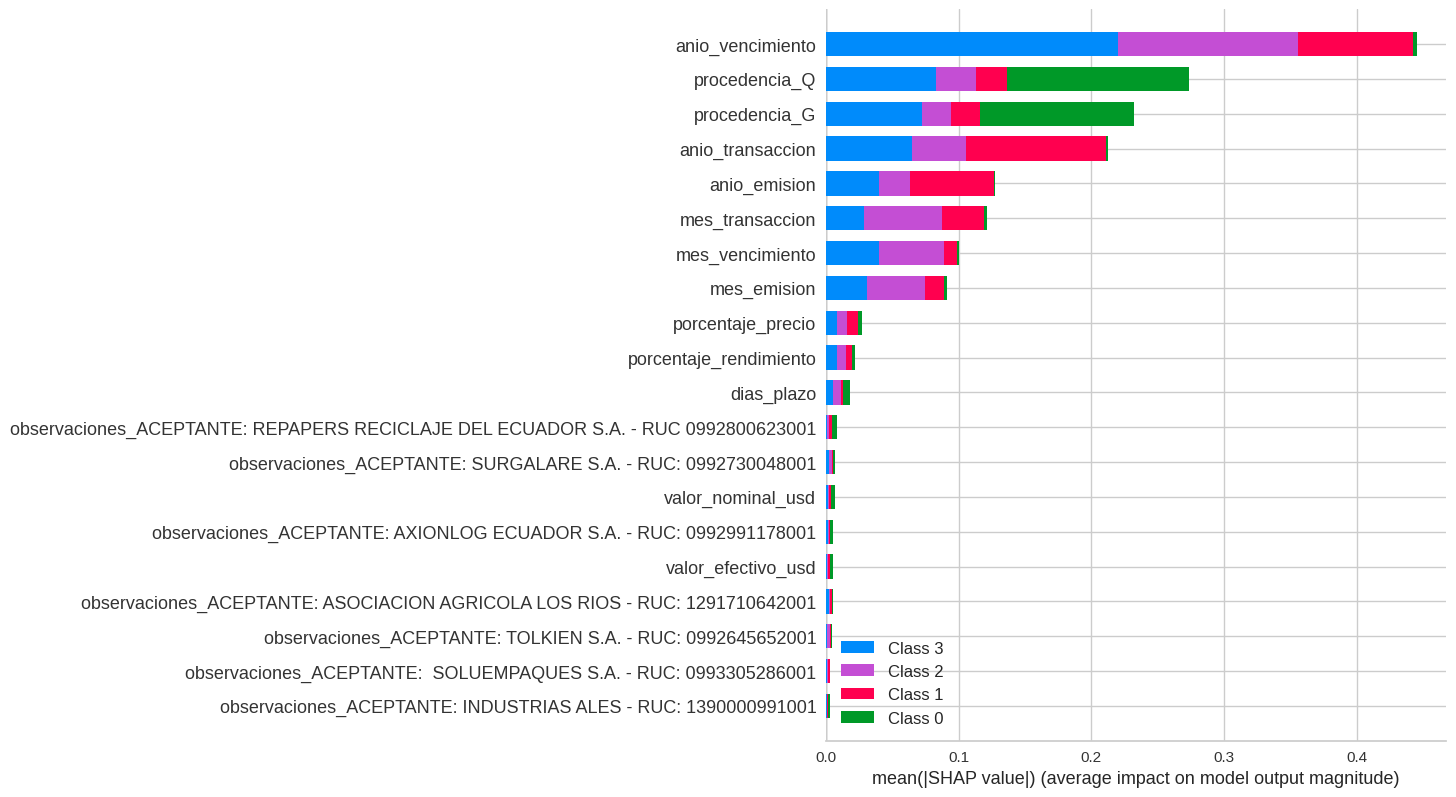

In [ ]:
# Se representan gráficamente las características que más incidencia tienen al momento de realizar el agrupamiento en clústeres.
shap.summary_plot(shap_values, df_ftr)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


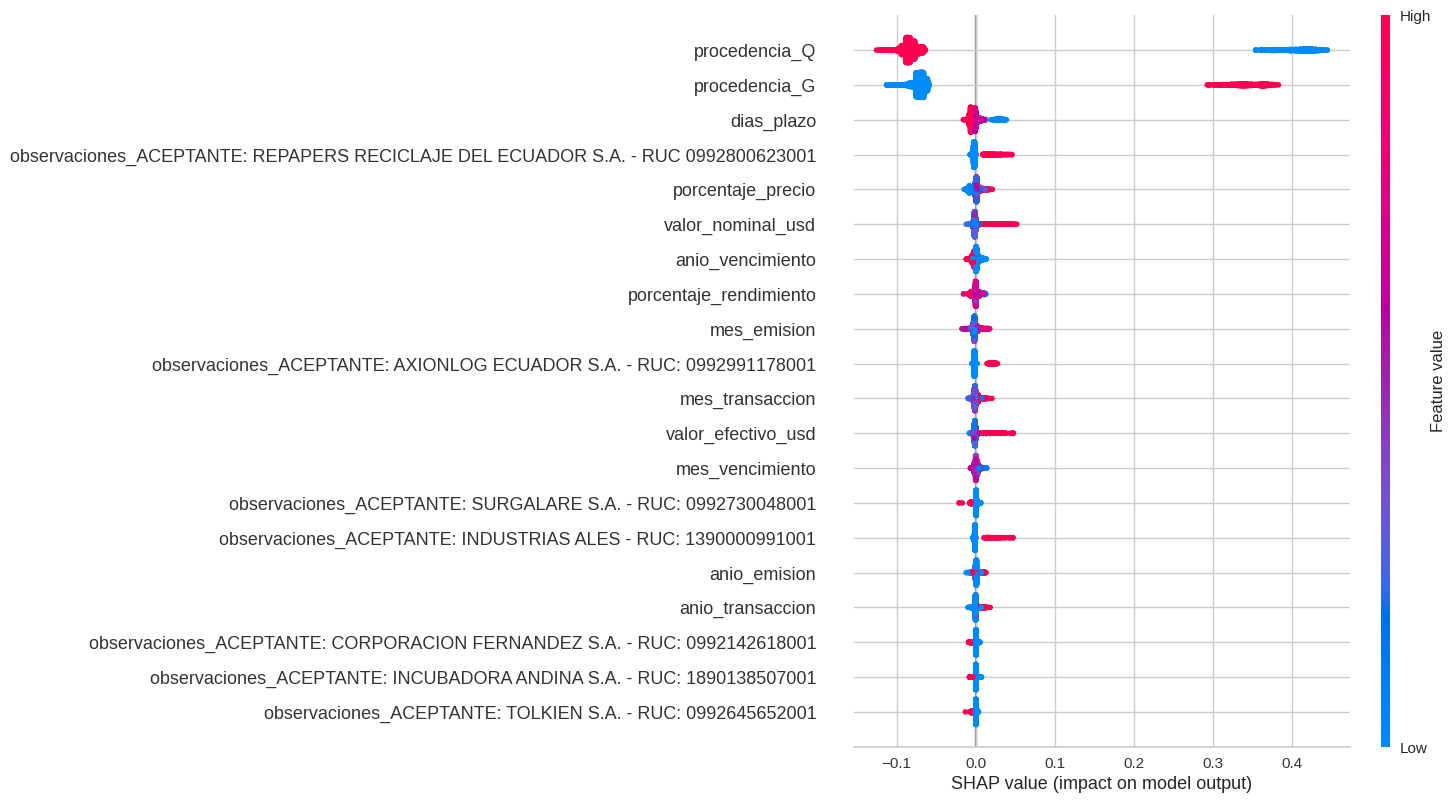

In [ ]:
#  Se observa la representación del clúster 0
shap.summary_plot(shap_values[0], df_ftr)

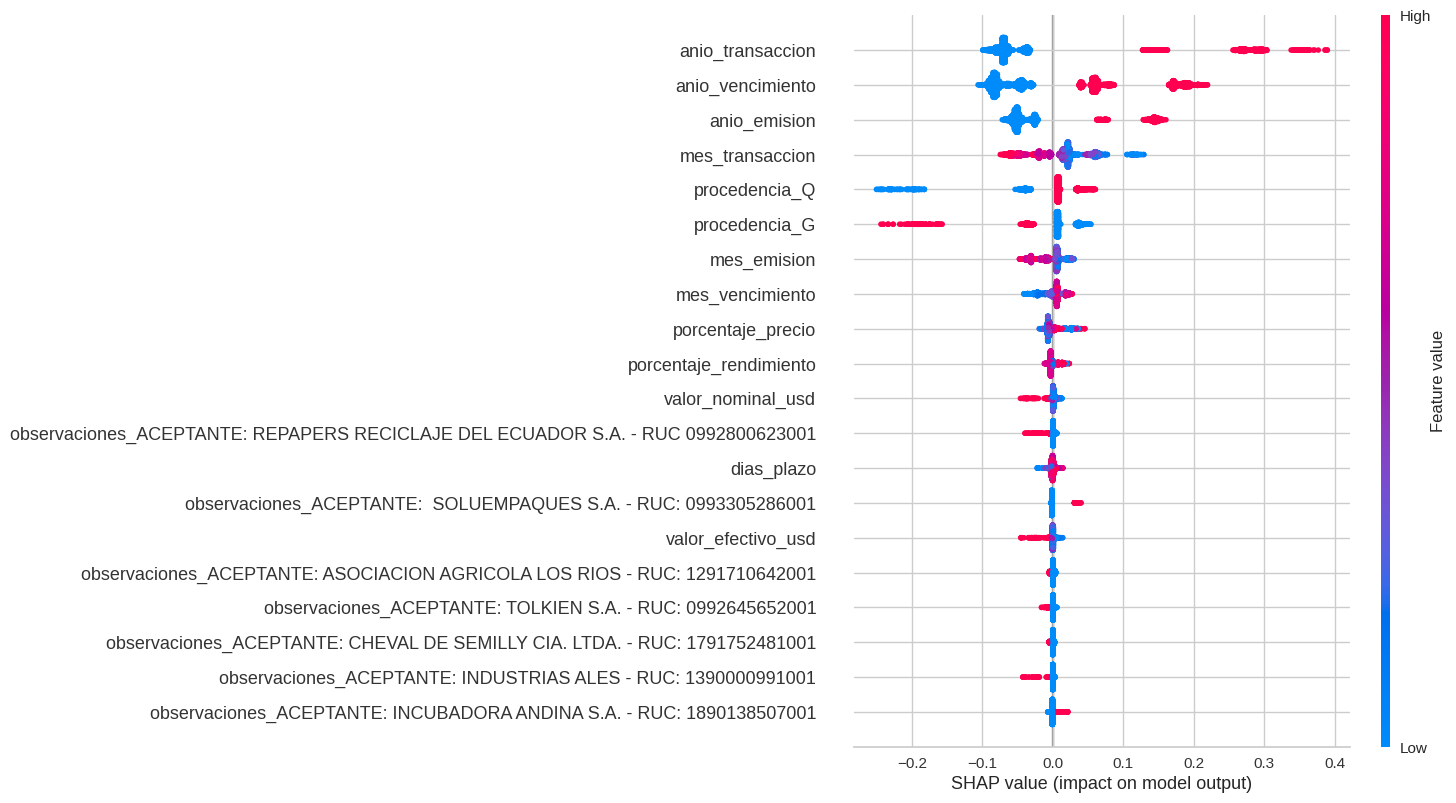

In [ ]:
#  Se observan la representación del clúster 1
shap.summary_plot(shap_values[1], df_ftr)

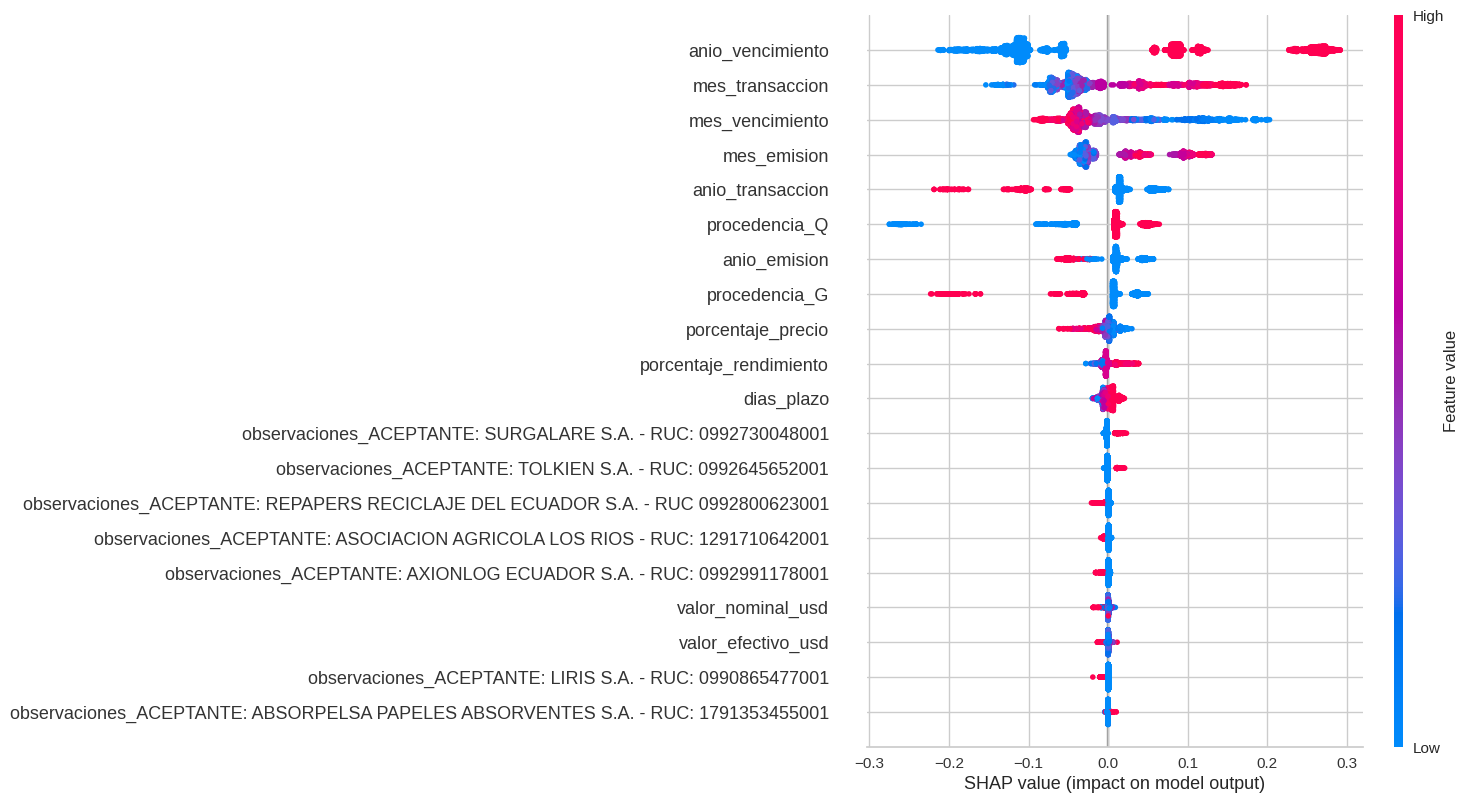

In [ ]:
#  Se observan la representación del clúster 2
shap.summary_plot(shap_values[2], df_ftr)

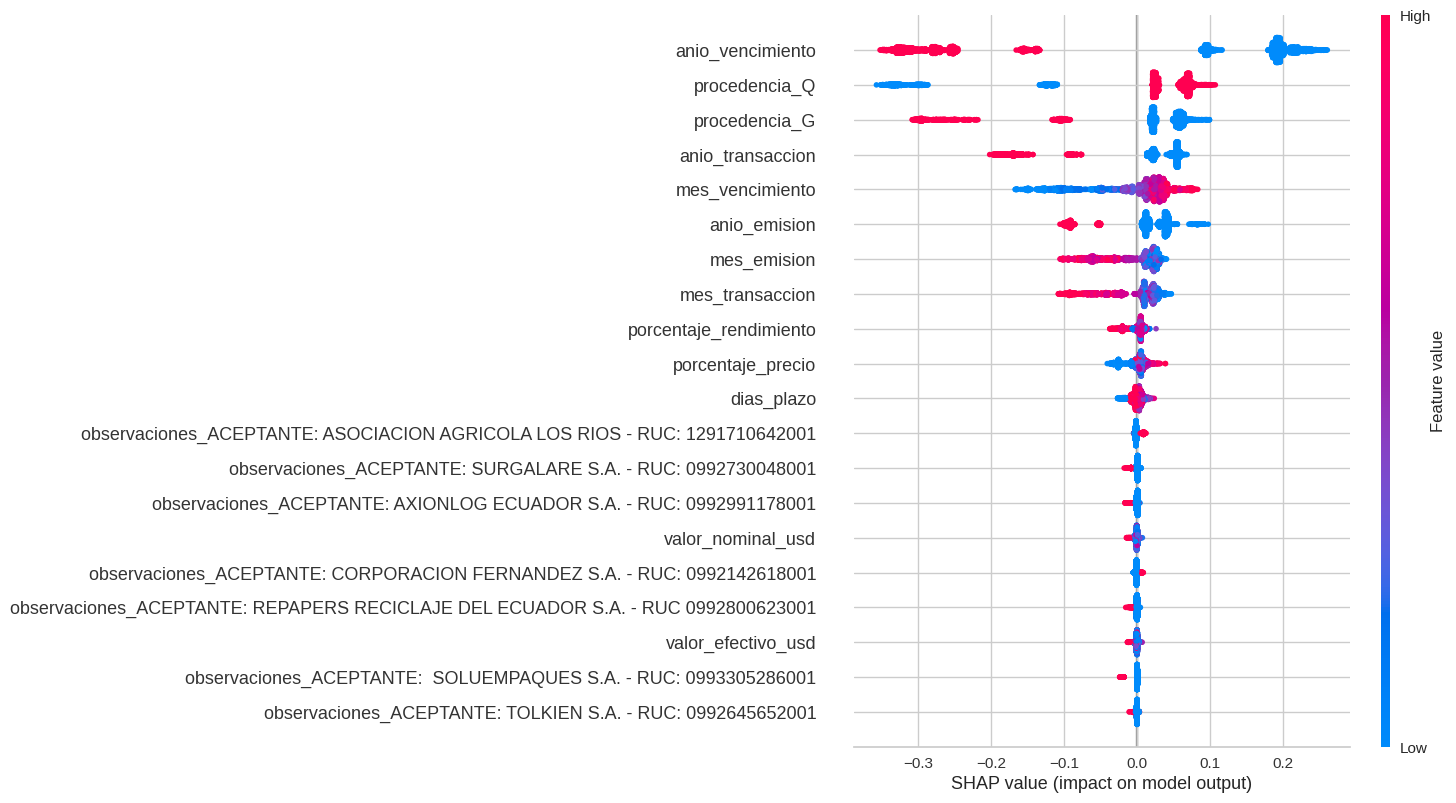

In [ ]:
#  Se observan la representación del clúster 3
shap.summary_plot(shap_values[3], df_ftr)

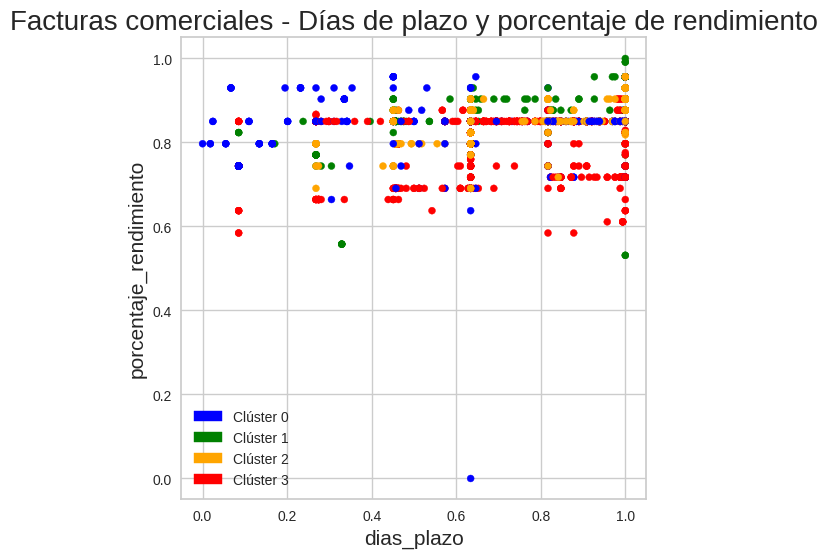

In [ ]:
# Con los datos obtenidos anteriormente no se puede determinar en cuál clúster es conveniente realizar inversiones.
# Para probar con otras características, se va a analizar la relación entre los días de plazo y el porcentaje de rendimiento entre los clústeres.

# Realizar gráfico, dándole un color diferente a cada clúster para mejor apreciación.
fig = plt.figure(figsize = (6,6))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel("dias_plazo", fontsize = 15)
ax.set_ylabel("porcentaje_rendimiento", fontsize = 15)
ax.set_title("Facturas comerciales - Días de plazo y porcentaje de rendimiento", fontsize = 20)
color = np.array(["blue", "green", "orange", "red"])
ax.scatter(x = df_sc_c.dias_plazo, y = df_sc_c.porcentaje_rendimiento, c = color[df_sc_c.cluster], s = 25)

# Crear etiquetas de la leyenda.
azul = mpatches.Patch(color = "blue", label = "Clúster 0")
verde = mpatches.Patch(color = "green", label = "Clúster 1")
naranja = mpatches.Patch(color = "orange", label = "Clúster 2")
rojo = mpatches.Patch(color = "red", label = "Clúster 3")

# Colocar la leyenda.
plt.legend(handles = [azul, verde, naranja, rojo])

plt.show()

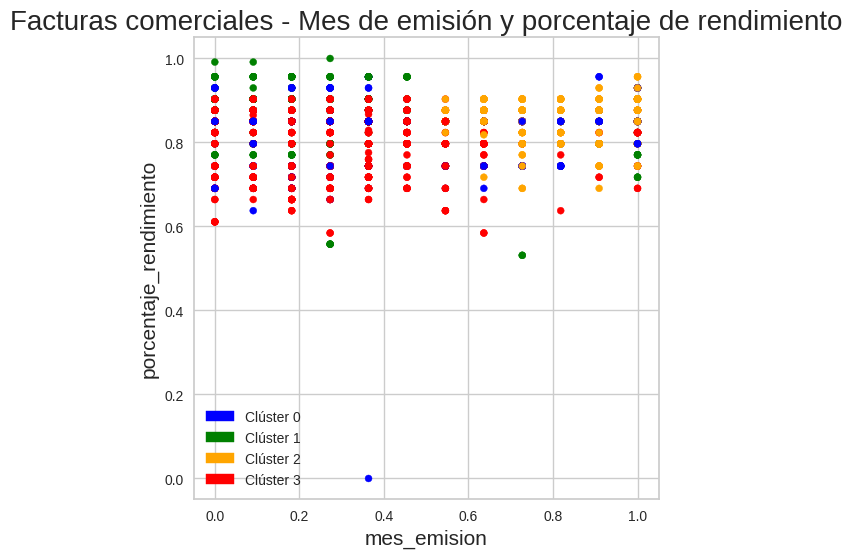

In [ ]:
# Se analiza el mes de emisión y el porcentaje de rendimiento entre los clústeres.

# Realizar gráfico, dándole un color diferente a cada clúster para mejor apreciación.
fig = plt.figure(figsize = (6,6))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel("mes_emision", fontsize = 15)
ax.set_ylabel("porcentaje_rendimiento", fontsize = 15)
ax.set_title("Facturas comerciales - Mes de emisión y porcentaje de rendimiento", fontsize = 20)
color = np.array(["blue", "green", "orange", "red"])
ax.scatter(x = df_sc_c.mes_emision, y = df_sc_c.porcentaje_rendimiento, c = color[df_sc_c.cluster], s = 25)

# Crear etiquetas de la leyenda.
azul = mpatches.Patch(color = "blue", label = "Clúster 0")
verde = mpatches.Patch(color = "green", label = "Clúster 1")
naranja = mpatches.Patch(color = "orange", label = "Clúster 2")
rojo = mpatches.Patch(color = "red", label = "Clúster 3")

# Colocar la leyenda.
plt.legend(handles = [azul, verde, naranja, rojo])

plt.show()

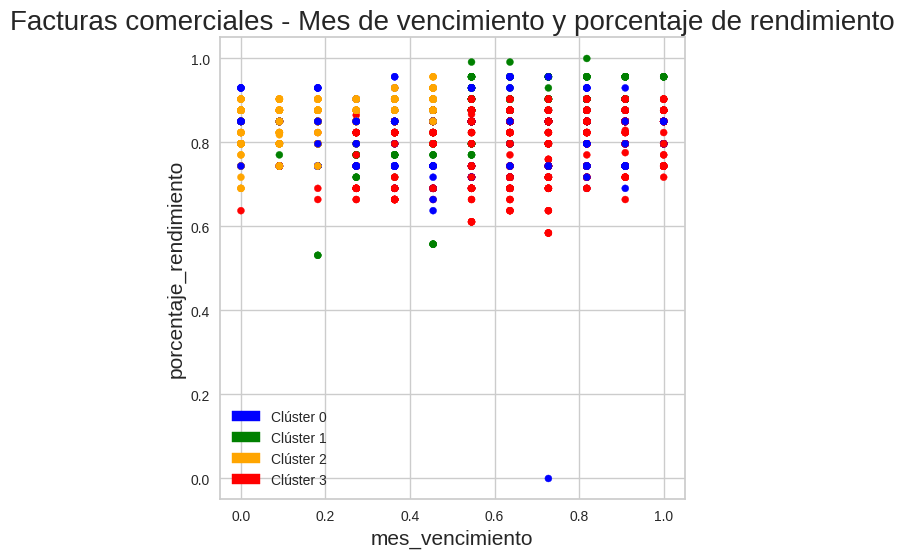

In [ ]:
# Se analiza el mes de vencimiento y el porcentaje de rendimiento entre los clústeres.

# Realizar gráfico, dándole un color diferente a cada clúster para mejor apreciación.
fig = plt.figure(figsize = (6,6))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel("mes_vencimiento", fontsize = 15)
ax.set_ylabel("porcentaje_rendimiento", fontsize = 15)
ax.set_title("Facturas comerciales - Mes de vencimiento y porcentaje de rendimiento", fontsize = 20)
color = np.array(["blue", "green", "orange", "red"])
ax.scatter(x = df_sc_c.mes_vencimiento, y = df_sc_c.porcentaje_rendimiento, c = color[df_sc_c.cluster], s = 25)

# Crear etiquetas de la leyenda.
azul = mpatches.Patch(color = "blue", label = "Clúster 0")
verde = mpatches.Patch(color = "green", label = "Clúster 1")
naranja = mpatches.Patch(color = "orange", label = "Clúster 2")
rojo = mpatches.Patch(color = "red", label = "Clúster 3")

# Colocar la leyenda.
plt.legend(handles = [azul, verde, naranja, rojo])

plt.show()

In [ ]:
# Finalmente, se obtienen los listados de las empresas que corresponden a cada clúster.

# Clúster 0
sorted(df[df.cluster == 0]["emisor"].unique().tolist())

['ABSORPELSA PAPELES ABSORVENTES SA',
 'ASTRIVEN SA',
 'DITEINCORP SA',
 'DREAMPACK ECUADOR SA',
 'ELECTRICA HAMT COMPAÑIA LIMITADA',
 'ELECTRO INDUSTRIAL MICABAL SA',
 'FERRETERIA COMERCIAL FECO SA',
 'HIVIMAR SA',
 'HOTELES Y RESTAURANTES HORPAH C',
 'INDUSTRIAL GEMINIS INDUGEM S.A',
 'LIPROIN SA',
 'MOLSANDO MOLINOS SANTO DOMINGO SA',
 'NEDERAGRO S A',
 'PABLO GUILLEN CORDOVA CIA LTDA',
 'PRODUCTORA CARTONERA S.A.',
 'REPAPERS RECICLAJE DEL ECUADOR SA',
 'ROQUIMIM SA',
 'SURGALARE SA',
 'SURPAPELCORP S A']

In [ ]:
# Clúster 1
sorted(df[df.cluster == 1]["emisor"].unique().tolist())

['ABSORPELSA PAPELES ABSORVENTES SA',
 'ECUADPREMEX SA',
 'ELECTRICA HAMT COMPAÑIA LIMITADA',
 'ELECTRO INDUSTRIAL MICABAL SA',
 'FERRETERIA COMERCIAL FECO SA',
 'HIVIMAR SA',
 'IMPVET IMPORTADORA VETERINARIA CIA LTDA',
 'INDUSTRIAL GEMINIS INDUGEM S.A',
 'LIPROIN SA',
 'MULTICOMERCIO PECUARIO MULTICOPEC',
 'NEDERAGRO S A',
 'PABLO GUILLEN CORDOVA CIA LTDA',
 'PRODUCTORA CARTONERA S.A.',
 'PROTECALEMAN REPRESENTACIONES QUIM S A',
 'ROQUIMIM SA',
 'SURGALARE SA',
 'SURPAPELCORP S A',
 'TADEC TECNICOS AGROPECUARIOS DEL ECUADOR',
 'THE TESALIA SPRINGS COMPANY SA',
 'VECTORQUIM CIA LTDA']

In [ ]:
# Clúster 2
sorted(df[df.cluster == 2]["emisor"].unique().tolist())

['ABSORPELSA PAPELES ABSORVENTES SA',
 'ASTRIVEN SA',
 'DITEINCORP SA',
 'ECUADPREMEX SA',
 'ELECTRICA HAMT COMPAÑIA LIMITADA',
 'HIVIMAR SA',
 'IMPVET IMPORTADORA VETERINARIA CIA LTDA',
 'INDUSTRIAL GEMINIS INDUGEM S.A',
 'LIPROIN SA',
 'MOLSANDO MOLINOS SANTO DOMINGO SA',
 'MULTICOMERCIO PECUARIO MULTICOPEC',
 'PABLO GUILLEN CORDOVA CIA LTDA',
 'PRODUCTORA CARTONERA S.A.',
 'PROTECALEMAN REPRESENTACIONES QUIM S A',
 'REPAPERS RECICLAJE DEL ECUADOR SA',
 'ROQUIMIM SA',
 'SURGALARE SA',
 'TADEC TECNICOS AGROPECUARIOS DEL ECUADOR',
 'VECTORQUIM CIA LTDA']

In [ ]:
# Clúster 3
sorted(df[df.cluster == 3]["emisor"].unique().tolist())

['ABSORPELSA PAPELES ABSORVENTES SA',
 'ASTRIVEN SA',
 'DITEINCORP SA',
 'DREAMPACK ECUADOR SA',
 'ECUADPREMEX SA',
 'ELECTRICA HAMT COMPAÑIA LIMITADA',
 'ELECTRO INDUSTRIAL MICABAL SA',
 'FERRETERIA COMERCIAL FECO SA',
 'HIVIMAR SA',
 'HOTELES Y RESTAURANTES HORPAH C',
 'IMPVET IMPORTADORA VETERINARIA CIA LTDA',
 'INDUSTRIAL GEMINIS INDUGEM S.A',
 'LIPROIN SA',
 'MOLSANDO MOLINOS SANTO DOMINGO SA',
 'MULTICOMERCIO PECUARIO MULTICOPEC',
 'PABLO GUILLEN CORDOVA CIA LTDA',
 'PRODUCTORA CARTONERA S.A.',
 'REPAPERS RECICLAJE DEL ECUADOR SA',
 'ROQUIMIM SA',
 'SURGALARE SA',
 'SURPAPELCORP S A',
 'TADEC TECNICOS AGROPECUARIOS DEL ECUADOR',
 'VECTORQUIM CIA LTDA']